# RNN with TensorFlow API

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [55]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,
                   return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (
            self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,
                            steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1,steps, 1),\
                    y_batch[:, 1:].reshape(-1, steps, 1) ,\
                    batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1),\
                    y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [56]:
ts_data = TimeSeriesData(250,0,10)

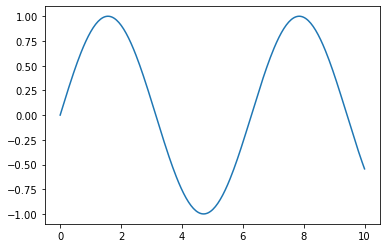

In [57]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [58]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 50

In [59]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

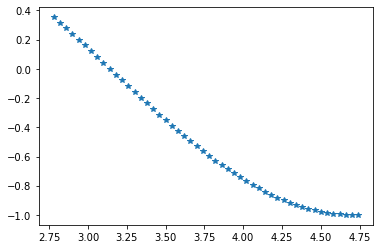

In [60]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

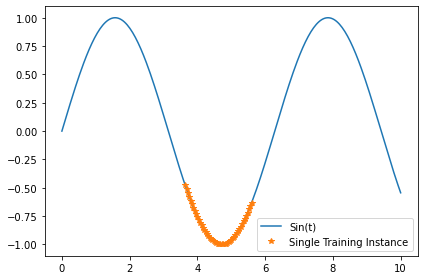

In [9]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',
         label='Single Training Instance')
plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [10]:
train_inst = np.linspace(
    5,5 + ts_data.resolution * (num_time_steps + 1),
    num_time_steps+1)

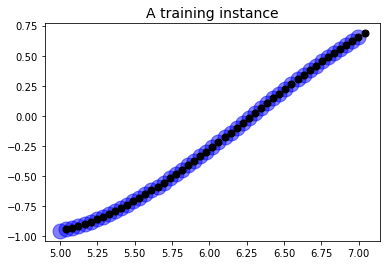

In [11]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]),
         "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]),
         "ko", markersize=7, label="target")

___________

# Creating the Model

In [12]:
tf.reset_default_graph()

### Constants

In [13]:
# Just one feature, the time series
num_inputs = 1
# 200 neuron layer, play with this
num_neurons = 200
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.001 default, but you can play with this
learning_rate = 0.001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 10000
# Size of the batch of data
batch_size = 30

### Placeholders

In [14]:
X = tf.placeholder(tf.float32,
                   [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32,
                   [None, num_time_steps, num_outputs])

____
____
### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [17]:
n_neurons = 100
n_layers = 3

cell = tf.nn.rnn_cell.MultiRNNCell(
[tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons
                             , activation=tf.nn.relu)
          for layer in range(n_layers)])

In [16]:
n_neurons = 100
cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=num_neurons,
                                    activation=tf.nn.relu)

C:\Users\Farid\anaconda3-NEW\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:699: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "


_____
_____

### Dynamic RNN Cell

In [18]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Farid\anaconda3-NEW\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Loss Function and Optimizer

In [19]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [20]:
init = tf.global_variables_initializer()

## Session

In [21]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.75)

In [22]:
saver = tf.train.Saver()

In [23]:
with tf.Session(
    config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, 
                                              num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(
                feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    mse = loss.eval(
            feed_dict={X: X_batch, y: y_batch})
    print(iteration, "\tMSE:", mse)
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.4852849
100 	MSE: 0.26164728
200 	MSE: 0.29789436
300 	MSE: 0.30123478
400 	MSE: 0.36818358
500 	MSE: 0.2575936
600 	MSE: 0.27205855
700 	MSE: 0.2519759
800 	MSE: 0.27307922
900 	MSE: 0.27408338
1000 	MSE: 0.2783939
1100 	MSE: 0.26664448
1200 	MSE: 0.31023747
1300 	MSE: 0.28397465
1400 	MSE: 0.3536098
1500 	MSE: 0.3141591
1600 	MSE: 0.30684313
1700 	MSE: 0.27657485
1800 	MSE: 0.24108784
1900 	MSE: 0.3439979
2000 	MSE: 0.36686003
2100 	MSE: 0.3011764
2200 	MSE: 0.27291426
2300 	MSE: 0.2580923
2400 	MSE: 0.26055
2500 	MSE: 0.2605219
2600 	MSE: 0.2574339
2700 	MSE: 0.30051476
2800 	MSE: 0.32975218
2900 	MSE: 0.30956236
3000 	MSE: 0.23036583
3100 	MSE: 0.25170812
3200 	MSE: 0.32125574
3300 	MSE: 0.27161208
3400 	MSE: 0.3277369
3500 	MSE: 0.29312047
3600 	MSE: 0.24251427
3700 	MSE: 0.35185257
3800 	MSE: 0.38311288
3900 	MSE: 0.30573255
4000 	MSE: 0.29344434
4100 	MSE: 0.33472052
4200 	MSE: 0.2953657
4300 	MSE: 0.2870643
4400 	MSE: 0.30066332
4500 	MSE: 0.34613904
4600 	MSE: 0.3342

### Predicting a time series t+1

In [24]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,
                                num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [25]:
X_new

array([[[-0.95892427],
        [-0.94655605],
        [-0.93261236],
        [-0.91711643],
        [-0.90009404],
        [-0.88157353],
        [-0.86158571],
        [-0.84016387],
        [-0.81734365],
        [-0.79316303],
        [-0.76766227],
        [-0.7408838 ],
        [-0.7128722 ],
        [-0.68367409],
        [-0.65333807],
        [-0.62191462],
        [-0.58945605],
        [-0.55601639],
        [-0.52165129],
        [-0.48641795],
        [-0.450375  ],
        [-0.41358245],
        [-0.37610153],
        [-0.33799463],
        [-0.29932516],
        [-0.26015749],
        [-0.22055682],
        [-0.18058904],
        [-0.1403207 ],
        [-0.0998188 ],
        [-0.05915076],
        [-0.01838427],
        [ 0.02241282],
        [ 0.0631726 ],
        [ 0.10382724],
        [ 0.14430906],
        [ 0.1845507 ],
        [ 0.22448517],
        [ 0.26404601],
        [ 0.30316736],
        [ 0.34178412],
        [ 0.37983201],
        [ 0.41724771],
        [ 0

In [41]:
y_pred[-1]

array([[0.        , 0.01068248, 0.00107879, ..., 0.00906011, 0.01056411,
        0.01014748],
       [0.        , 0.02103454, 0.00992266, ..., 0.01341822, 0.02116429,
        0.01395154],
       [0.        , 0.00551077, 0.00077319, ..., 0.00031442, 0.00901131,
        0.0093343 ],
       ...,
       [0.        , 0.01303277, 0.00957185, ..., 0.01114411, 0.01368963,
        0.01163112],
       [0.        , 0.0130326 , 0.00957162, ..., 0.0111441 , 0.01368942,
        0.01163094],
       [0.        , 0.01303251, 0.00957157, ..., 0.01114407, 0.0136895 ,
        0.01163087]], dtype=float32)

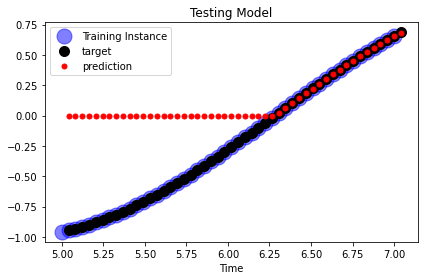

In [36]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]),
     "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]),
         "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,-1], "r.",
         markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

In [28]:
np.sin(train_inst[1:])

array([-0.94655605, -0.93261236, -0.91711643, -0.90009404, -0.88157353,
       -0.86158571, -0.84016387, -0.81734365, -0.79316303, -0.76766227,
       -0.7408838 , -0.7128722 , -0.68367409, -0.65333807, -0.62191462,
       -0.58945605, -0.55601639, -0.52165129, -0.48641795, -0.450375  ,
       -0.41358245, -0.37610153, -0.33799463, -0.29932516, -0.26015749,
       -0.22055682, -0.18058904, -0.1403207 , -0.0998188 , -0.05915076,
       -0.01838427,  0.02241282,  0.0631726 ,  0.10382724,  0.14430906,
        0.1845507 ,  0.22448517,  0.26404601,  0.30316736,  0.34178412,
        0.37983201,  0.41724771,  0.45396893,  0.48993457,  0.52508475,
        0.55936098,  0.5927062 ,  0.62506491,  0.65638327,  0.68660913])

In [29]:
y_pred

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.6236928 , 0.62388176, ..., 0.6225339 ,
         0.62208164, 0.6231746 ],
        [0.        , 0.654929  , 0.65537316, ..., 0.653802  ,
         0.65360737, 0.6544078 ],
        [0.        , 0.68508583, 0.68545324, ..., 0.68403995,
         0.6836297 , 0.6846902 ]]], dtype=float32)

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

In [47]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, -1])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0, 0.5, 'Value')

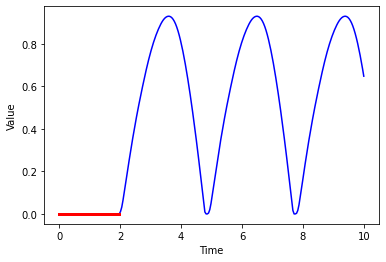

In [48]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps],
         zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0.5, 0, 'Time')

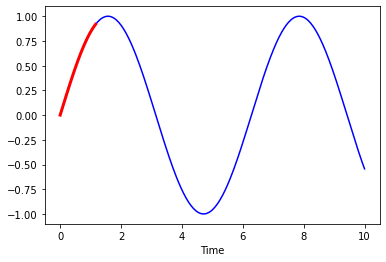

In [54]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:30],
         training_instance[:30], "r-", linewidth=3)
plt.xlabel("Time")